In [227]:
import pandas as pd
from datetime import timedelta  
import matplotlib.pyplot as plt

In [228]:
users = pd.read_csv(r"takehome_users.csv", encoding = "iso-8859-1")
user_engagement = pd.read_csv(r"takehome_user_engagement.csv")

In [229]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [230]:
engagement_counts = user_engagement.groupby("user_id")['visited'].count().reset_index()

# I tried to clean the data using the below solution, as I understood that any 3 purchases within 7 days of eachother would be considered retained. I couldn't quite get there

In [232]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
date = pd.DatetimeIndex(user_engagement['time_stamp'])
# compute df2: totals by month
user_engagement['7days'] = date.to_period('7D')
count_engagement = user_engagement[user_engagement['visited'] == 1].groupby(['user_id', '7days']).sum()
is_within_seven = date.to_period("7D") != (date + timedelta(days = 7)).to_period('7D')
df3 = user_engagement[(user_engagement['visited'] == 1) & is_within_seven].groupby(['user_id', user_engagement.day + 7]).sum()
result = count_engagement.join(df3, rsuffix="_within_seven")

AttributeError: 'DataFrame' object has no attribute 'day'

https://stackoverflow.com/questions/33914458/pandas-count-values-for-last-7-days-from-each-date

https://stackoverflow.com/questions/49164935/how-to-use-loc-with-groupby-and-two-conditions-in-pandas
using groupby, .loc and multiple conditions
https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates
between two dates


In [233]:
user_engagement.head()

,time_stamp,user_id,visited,7days
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [234]:
# Convert that column into a datetime datatype
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
# Set the datetime column as the index
user_engagement.index = user_engagement['time_stamp'] 
user_engagement['7day period sum'] = user_engagement['time_stamp'].resample('7D').count()

In [235]:
date = pd.DatetimeIndex(user_engagement['time_stamp'])
date = pd.DatetimeIndex(user_engagement['time_stamp'])

In [236]:
user_engagement_group_user = user_engagement.groupby('user_id')['time_stamp'].resample('7D').count().reset_index(name = 'reset')

In [237]:
adopted = user_engagement_group_user.loc[user_engagement_group_user['reset'] >= 3]

In [238]:
len(adopted)

33897

In [239]:
adopted_unique = pd.unique(adopted['user_id'])

In [240]:
len(adopted_unique)

1472

In [241]:
adopted_unique = pd.Series(adopted_unique)

In [242]:
full_data = user_engagement.merge(users, how = "outer", left_on = "user_id", right_on = "object_id")

In [243]:
full_data.index = full_data['user_id']

In [244]:
check_adopted_users = full_data.index.isin(adopted_unique)

In [245]:
full_data['check adopted users'] = check_adopted_users

In [246]:
full_data['adopted'] = 0

In [247]:
full_data.loc[full_data['check adopted users'] == True, 'adopted'] = 1

In [248]:
full_data = full_data.drop_duplicates(subset = "user_id", keep = 'first')

In [249]:
full_data.loc[full_data['adopted'] == 1]['creation_source'].value_counts()

ORG_INVITE            504
GUEST_INVITE          332
SIGNUP                275
SIGNUP_GOOGLE_AUTH    217
PERSONAL_PROJECTS     144
Name: creation_source, dtype: int64

In [250]:
full_data.loc[full_data['adopted'] == 0]['creation_source'].value_counts()

ORG_INVITE            2684
SIGNUP                1623
GUEST_INVITE          1256
SIGNUP_GOOGLE_AUTH    1168
PERSONAL_PROJECTS      621
Name: creation_source, dtype: int64

- linear regression to see the relationship between number of login times and other variables 

In [253]:
creation_time = full_data
creation_time['creation_time'] = pd.to_datetime(creation_time['creation_time'])
adopted = creation_time.loc[creation_time['adopted'] == 1]
not_adopted = creation_time.loc[creation_time['adopted'] == 0]
# Convert that column into a datetime datatype
adopted.index = adopted['creation_time']
not_adopted.index = not_adopted['creation_time']

In [254]:
adopted_monthly = adopted['creation_time'].resample('1M').count()

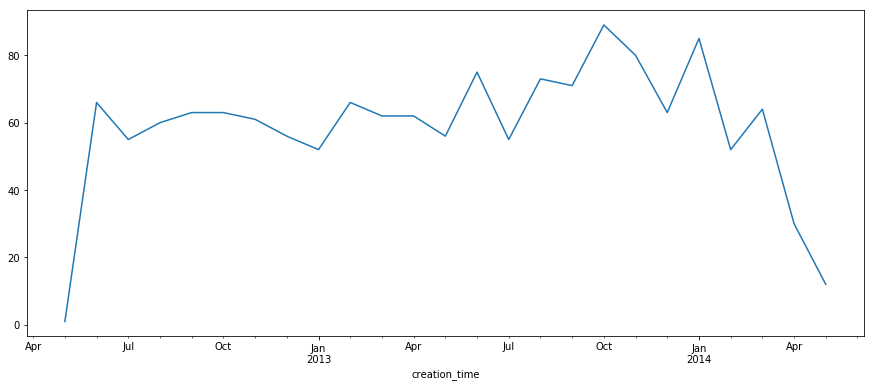

In [255]:
adopted_monthly.plot(figsize=(15, 6))

In [256]:
not_adopted_monthly = not_adopted['creation_time'].resample('1M').count()

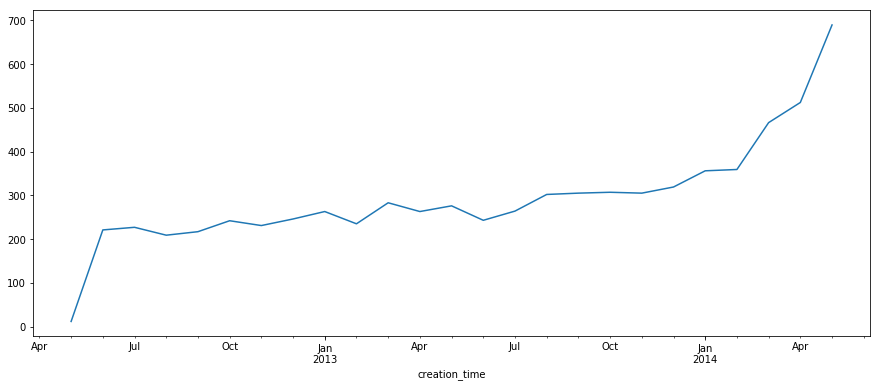

In [257]:
not_adopted_monthly.plot(figsize=(15, 6))

In [258]:
full_data.loc[full_data['adopted'] == 0]['enabled_for_marketing_drip'].value_counts()

0    6237
1    1115
Name: enabled_for_marketing_drip, dtype: int64

In [259]:
full_data.loc[full_data['adopted'] == 1]['enabled_for_marketing_drip'].value_counts()

0    1245
1     227
Name: enabled_for_marketing_drip, dtype: int64

In [260]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
def test_adopted(difference_col, dataframe, alternative_hyp = False):
    dataframe.loc[dataframe['adopted'] == 0]
    dataframe.loc[dataframe['adopted'] == 1]
    dataframe.loc[(dataframe['adopted'] == 0) & (dataframe[difference_col] == 1)]
    dataframe.loc[(dataframe['adopted'] == 1) & (dataframe[difference_col] == 0)]
    count = np.array([len(dataframe.loc[(dataframe['adopted'] == 0) & (dataframe[difference_col] == 1)]), len(dataframe.loc[(dataframe['adopted'] == 1) & (dataframe[difference_col] == 1)])])
    # create a numpy array of total number of resumes sent for white and black
    nobs = np.array([len(dataframe.loc[dataframe['adopted'] == 0]), len(dataframe.loc[dataframe['adopted'] == 1])])
    # run proportions z test assuming null hypothesis is true, hence "larger" as argument for alternative
    z, p = proportions_ztest(count, nobs, alternative = alternative_hyp )
    return (z, p)

In [261]:
z_marketing, p_marketing = test_adopted('enabled_for_marketing_drip', full_data, alternative_hyp = 'smaller')
print (z_marketing, p_marketing)

-0.2489301787797955 0.40170739531816735


In [262]:
z_email, p_email = test_adopted('opted_in_to_mailing_list', full_data, alternative_hyp = 'smaller')
print (z_email, p_email)

-0.887237563128436 0.18747550641477784


In [357]:
full_data['creation_time'] = pd.to_datetime(full_data['creation_time'])
full_data['month'] = full_data['creation_time'].apply(lambda x: x.month)
print (full_data.loc[full_data['adopted'] ==1]['month'].value_counts())
print (full_data.loc[full_data['adopted'] ==0]['month'].value_counts())

10    152
11    141
6     141
1     137
9     134
8     133
3     126
12    119
2     118
7     110
4      92
5      69
Name: month, dtype: int64
5     977
4     775
3     749
1     619
2     594
12    565
10    549
11    536
9     522
8     511
7     491
6     464
Name: month, dtype: int64


# Train Random Forest and Logistic Regression Models

Through EDA, I was able to identify a few variables that might be helpful in training a random forest or logistic regression model to predict which users will become adopted users. 

    -In an attempt to maximize time, some EDA simply looked at value counts of certain categorical variables between adopted      users and un-adopted users. These variables were:
        - Month a feature that was created
        - Creation Source, creation_source (specifically looking at whether or not value was SIGNUP
    - Time series analysis of adopted users indicates that the creation time of profiles of adopted users is consistent,
     decreasing however, probably due to the data being pulled recently, meaning that users who signed up during this time 
     still have potential to become adopted users
     
    - Time series analysis of the sign-ups of non-adopted users indicates that the number of sign-ups in the 2014 year has 
      increased dramatically. Of both time-series analysis figures, however, neither indicates time as a relevant predictor 
      for adopted user status
      
    - proportions z tests of users who are enabled for the marketing drip or opted into the mailing list both do not
      indicate statistically significant differences in proportions between adopted users and non-adopted users. However, a       p-value of .18, indicating a .18 chance of the true proportion of adopted users opting into the e-mail list not being 
      greater than that of non-users. 

In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import sklearn


In [264]:
len(adopted), len(not_adopted)

(1472, 7352)

There is a significantly greater number of non-adopted users in the dataset, which indicates a need to weight the data, in the training model.

In [366]:
full_data['sign_up'] = 0
full_data.loc[full_data['creation_source'] == "SIGNUP", 'sign_up'] = 1
full_data_dummies = pd.get_dummies(full_data['creation_source'])
full_data_dummies = full_data.merge(full_data_dummies, how= "outer", left_on = "user_id", right_on = "user_id")
# take the features that we want to use to train the forest
X = full_data_dummies[["GUEST_INVITE", "ORG_INVITE", "PERSONAL_PROJECTS", "SIGNUP", "SIGNUP_GOOGLE_AUTH", "opted_in_to_mailing_list", "month"]]
# set the target dataset to train and convert column to array
y = full_data[['adopted']]

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


In [369]:
# split data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# creat a gaussian classifier
clf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced_subsample')
# train the model using the training sets
clf.fit(X_train, y_train.values.ravel())
# predict the y values
all_features_pred = clf.predict(X_test)
all_features_pred_accu = metrics.accuracy_score(y_test, all_features_pred)
all_features_pred_rec = metrics.recall_score(y_test, all_features_pred)
all_features_pred_prec = metrics.precision_score(y_test, all_features_pred)
print("Accuracy:", all_features_pred_accu)
print ("Recall:",all_features_pred_rec)
print ("Precision:", all_features_pred_prec)
matrix = confusion_matrix(y_test, all_features_pred)
print (matrix)

Accuracy: 0.5725075528700906
Recall: 0.48259860788863107
Precision: 0.18621307072515667
[[1308  909]
 [ 223  208]]


In [368]:
feature_imp = pd.Series(clf.feature_importances_,index = X.columns).sort_values(ascending = False)
feature_imp

month                       0.798667
opted_in_to_mailing_list    0.069033
GUEST_INVITE                0.045686
SIGNUP                      0.026273
ORG_INVITE                  0.022897
SIGNUP_GOOGLE_AUTH          0.020617
PERSONAL_PROJECTS           0.016827
dtype: float64

# Analyzing Results of the Model

The Random Forest model does not produce a very high accuracy.  Organization Id is indicated as the most important feature in predicting adopted and non-adopted users. However, low precision and recall scores call for an approach of caution when using this model. The low precision indicates that a large number of true adopted users are being classified as not adopted. This may be important depending on the use of the model. If it is being used for marketing purposes, the marketing could potentially miss a large number of key users who will adopt. 

Overall, the company might want to change their definition of adopted and not-adopted users to get a higher accuracy. A user using 3 times in any seven day period does not necessarily indicate whether that user is active, ie, truly adopted. It would be better to track if a user logs in maybe 3 times in a two-week period, and also does this 2 or 3 months after doing it for the first time. 

If the client base is not already homogenous with regards to industry, company size or company type, it may also be useful to collect categorical data on the type of organization. There may be a difference across organization types that tend to stick around with the product. 

Similarly, if the user base is not already homogenous with regards to job titles, it may be useful to collect categorical data on the job titles that tend to use the platform more. 